In [15]:
setwd("D:/2.crc_trio/results/")
suppdir="D:/2.crc_trio/results/plot/0.supp/"
maindir="D:/2.crc_trio/results/plot/fig"

library(openxlsx)
library(dplyr)
library(reshape2)

library(ggrepel)
library(ggplot2)
library(ggpubr)
library(ggrepel)
library(ggsci)
library(cowplot)
library(ggpmisc)
library(ggsignif)

library(ComplexHeatmap)
library(maftools)

library(dndscv)
library(VariantAnnotation)

library(breakclone)

source("D:/2.crc_trio/src/cnv-heatmap-master/src/CNVPlottingFunctions.R")

# data load and pre-processed

In [5]:
ls()

[1] "alter_fun"              "escc_pi"                "get_vcColors"          
 [4] "ls_escc_af"             "maindir"                "makeHeatmapAnnotations"
 [7] "plotCNVHeatmap"         "populateCNVMatrix"      "readMeta"              
[10] "readSeg"                "readSeg2"               "samples"               
[13] "suppdir"

In [11]:
#clincal characters, clonality, other stats for genomic changes
clin<-read.xlsx("./0.库检/7.肠镜标本病理.xlsx",sheet = 1,colNames = T,cols = c(1:31))
lineage<-read.xlsx(paste0(suppdir,"SupplementaryTable12.1_polyclonal.xlsx"))

#load post-data
sub<-read.csv(paste0(suppdir,"SupplementaryTable3.1_SubMut_VAFa0.04.csv"))
tmb<-read.csv(paste0(suppdir,"SupplementaryTable3.2_variant_summary.csv"))
driver<-read.csv(paste0(suppdir,"SupplementaryTable3.3_driver_summary.csv"))
msi<-read.csv(paste0(suppdir,"SupplementaryTable5_msi.csv"))
hlaloh<-read.csv(paste0(suppdir,"SupplementaryTable8_HLALOH.csv"))
tcell<-read.csv(paste0(suppdir,"SupplementaryTable9_Tcell.csv"))
neo<-read.csv(paste0(suppdir,"SupplementaryTable10.2_neo_num.csv"))

tmp0<-full_join(tmb,driver,by=c('Tumor_Sample_Barcode'))
tmp1<-full_join(sub[,1:6],tmp0,by=c('Sample'='Tumor_Sample_Barcode'))
tmp2<-full_join(msi[,c(1:6,8)],hlaloh,by=c('PatientID','SampleID'))
tmp3<-full_join(neo[,c(2:9)],tcell[grep("P|T",tcell$sample),c(2,5:12)],by=c('sample'))
tmp4<-full_join(tmp1,tmp2,by=c('Patient'='PatientID','Sample'='SampleID'))

dat<-full_join(tmp4,tmp3,by=c('Patient'='patient','Sample'='sample')) #

cnv_all=read.table('./7.gistic2/SupplementaryTable4_CNVsummary_all.txt',header = T,sep="\t")
cnv=reshape2::dcast(cnv_all,ID~type,value.var = "frac")

dat<-full_join(dat,cnv,by=c('Sample'='ID')) #

# excluded B082 and B127 due to only one type sample
dat = dat %>% filter(Patient != "B127" & Patient != "B082") %>% 
mutate(Age=clin$Age[match(Patient,clin$PatientID)],
       Lineage=lineage[match(Sample,lineage$SampleID),'Lineage'],
       #derived=ifelse(grepl("T",Sample),"T",paste0(derived,"_",Lineage)),
       #derived=factor(derived,levels=c("P_Polyclonal","P_Monoclonal","T"))
       derived=factor(paste0(derived,"_",Lineage),levels=c("P_Polyclonal","P_Monoclonal","T_Monoclonal","T_Polyclonal"))
      ) #

cnv_chr=read.table('./7.gistic2/SupplementaryTable4_CNVsummary_chr.txt',header = T,sep="\t")
GII=cnv_chr %>% filter(type == "FLA")
wGII=aggregate(frac~ID,GII,mean) %>% mutate(status=ifelse(frac>=20,"CIN+","CIN-"))
colnames(wGII)<-c('Sample','wGII','CIN_status')

dat<-left_join(dat,wGII,by="Sample") #

clonal_ccf_mean<-lapply(ls_escc_af,function(x) Mean=round(mean(x$CCF_adj[which(x$Clonality=="Clonal")]),2)) %>% as.data.frame()

dat=dat %>% mutate(Clonal_CCF_Mean=clonal_ccf_mean[,Sample] %>% t() %>% as.vector())

In [13]:
dat %>% filter(grepl("P$|T$",Sample)) %>% mutate(Clonal_f=round(ClonalSNP/total_SNP*100,2) ) %>% 
group_by(derived) %>% summarise(min(ClonalSNP),max(ClonalSNP),min(Clonal_f),max(Clonal_f),min(Clonal_CCF_Mean),max(Clonal_CCF_Mean))

dat %>% filter(grepl("P$|T$",Sample) & grepl("Polyclonal",Lineage) )%>% mutate(Clonal_f=round(ClonalSNP/total_SNP*100,2) ) %>% 
dplyr::select(matches('Patient|Sample|total_SNP|Clonal')) %>% arrange(desc(total_SNP)) %>% head()

min(ClonalSNP),max(ClonalSNP),min(Clonal_f),max(Clonal_f),min(Clonal_CCF_Mean),max(Clonal_CCF_Mean)
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
0,2086,0,96.07,NaN,NaN


,Patient,Sample,Clonal,Subclonal,ClonalSNP,SubclonalSNP,total_SNP,ClonalDriver,neo_clonal,neo_subclonal,neo_clonal_ccf,Clonal_CCF_Mean,Clonal_f
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,B116,B116P,704,2192,383,1521,1904,8,558,3193,0.8968817,0.91,20.12
2,B126,B126P,76,1600,66,1374,1440,4,38,1796,0.9173421,0.94,4.58
3,B010,B010P,95,969,69,814,883,1,128,1671,0.7392109,0.78,7.81
4,B015,B015T,19,327,19,312,331,2,15,370,0.8336667,0.83,5.74
5,B018,B018P,4,235,4,225,229,0,0,261,0.0000000,0.78,1.75
6,B059,B059T,1,239,1,225,226,0,0,562,0.0000000,0.70,0.44


In [ ]:
## 1.2 dnds estimation

In [15]:
data(list = sprintf("covariates_%s", "hg19_hg38_epigenome_pcawg"), package = "dndscv")
path_refdb = system.file("data", "RefCDS_human_GRCh38.p12_dNdScv.0.1.0.rda", package = "dndscv", mustWork = TRUE)
path_refdb
load(path_refdb)

data(list = sprintf("RefCDS_human_%s", "GRCh38.p12_dNdScv.0.1.0"), package = "dndscv")
gene_list = intersect(sapply(RefCDS, function(x) x$gene_name),row.names(covs))  #为了保持refdp的基因要在covs中，不然会报错

[1] "C:/software/R/R-4.1.0/library/dndscv/data/RefCDS_human_GRCh38.p12_dNdScv.0.1.0.rda"

In [18]:
maf=lapply(ls_escc_af, function(x){x$VAF_adj=x$CCF_adj/2; x[which(x$Clonality!="Unknown"),c("Tumor_Sample_Barcode","Chromosome","Start_Position","Reference_Allele","Tumor_Seq_Allele2","Hugo_Symbol","Variant_Classification")]})
MutTable <- data.table::rbindlist(maf)
colnames(MutTable)[1:5]=c("sampleID","chr", "pos", "ref", "mut")
MutTable$chr=paste0("chr",MutTable$chr)

In [23]:
dat$Patient %>% unique()

[1] "B001" "B002" "B003" "B004" "B005" "B006" "B007" "B008" "B009" "B010"
 [11] "B012" "B013" "B014" "B015" "B016" "B017" "B018" "B019" "B020" "B021"
 [21] "B022" "B023" "B024" "B025" "B026" "B027" "B028" "B029" "B030" "B031"
 [31] "B033" "B034" "B035" "B036" "B037" "B038" "B039" "B041" "B042" "B044"
 [41] "B045" "B046" "B048" "B049" "B050" "B051" "B052" "B053" "B054" "B056"
 [51] "B057" "B058" "B059" "B060" "B061" "B062" "B063" "B064" "B065" "B066"
 [61] "B067" "B068" "B069" "B071" "B073" "B074" "B075" "B076" "B077" "B079"
 [71] "B081" "B083" "B084" "B085" "B086" "B087" "B088" "B090" "B091" "B092"
 [81] "B093" "B094" "B095" "B096" "B097" "B098" "B099" "B100" "B102" "B104"
 [91] "B105" "B106" "B108" "B110" "B111" "B112" "B113" "B114" "B116" "B118"
[101] "B119" "B120" "B122" "B123" "B124" "B125" "B126"

In [25]:
##dnds for three groups

pp_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="P_Polyclonal" )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

pm_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="P_Monoclonal" )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

tp_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="T_Polyclonal" )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

tm_dndsout<-dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived=="T_Monoclonal" )]),1:5],
                gene_list = gene_list,    
                refdb = path_refdb, 
                outmats = T,
                max_coding_muts_per_sample = 5000,
                cv = "hg19_hg38_epigenome_pcawg") 

pp_site_out=sitednds(dndsout=pp_dndsout)
pm_site_out=sitednds(dndsout=pm_dndsout)
tp_site_out=sitednds(dndsout=tp_dndsout)
tm_site_out=sitednds(dndsout=tm_dndsout)

pp_ci=geneci(dndsout=pp_dndsout)
pm_ci=geneci(dndsout=pm_dndsout)
tp_ci=geneci(dndsout=tp_dndsout)
tm_ci=geneci(dndsout=tm_dndsout)

#save(p_dndsout,t_dndsout,p_site_out,t_site_out,p_ci,t_ci,file="runtime/output/step5_dndsout.RData")
#save(p_dndsout,mp_dndsout,pp_dndsout,t_dndsout,p_site_out,pp_site_out,mp_site_out,t_site_out,p_ci,pp_ci,mp_ci,t_ci,file="runtime/output/step5_dndsout.RData")

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived == :
"Mutations observed in contiguous sites within a sample. Please annotate or remove dinucleotide or complex substitutions for best results."
Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Sample[which(dat$derived == :
"Same mutations observed in different sampleIDs. Please verify that these are independent events and remove duplicates otherwise."
    Note: 11 mutations removed for exceeding the limit of mutations per gene per sample (see the max_muts_per_gene_per_sample argument in dndscv)

[3] Estimating global rates...

[4] Running dNdSloc...

[5] Running dNdScv...

    Regression model for substitutions (theta = 0.542).

    Regression model for indels (theta = 1.57)

[1] Loading the environment...

[2] Annotating the mutations...

Warning message in dndscv(MutTable[which(MutTable$sampleID %in% dat$Samp

[1] 0.052
[1] 0.1
[1] 0.16
[1] 0.21
[1] 0.26
[1] 0.31
[1] 0.36
[1] 0.42
[1] 0.47
[1] 0.52
[1] 0.57
[1] 0.62
[1] 0.68
[1] 0.73
[1] 0.78
[1] 0.83
[1] 0.88
[1] 0.94
[1] 0.99


Calculating CI95 across all genes...



[1] 0.052
[1] 0.1
[1] 0.16
[1] 0.21
[1] 0.26
[1] 0.31
[1] 0.36
[1] 0.42
[1] 0.47
[1] 0.52
[1] 0.57
[1] 0.62
[1] 0.68
[1] 0.73
[1] 0.78
[1] 0.83
[1] 0.88
[1] 0.94
[1] 0.99


Calculating CI95 across all genes...



[1] 0.052
[1] 0.1
[1] 0.16
[1] 0.21
[1] 0.26
[1] 0.31
[1] 0.36
[1] 0.42
[1] 0.47
[1] 0.52
[1] 0.57
[1] 0.62
[1] 0.68
[1] 0.73
[1] 0.78
[1] 0.83
[1] 0.88
[1] 0.94
[1] 0.99


Calculating CI95 across all genes...



[1] 0.052
[1] 0.1
[1] 0.16
[1] 0.21
[1] 0.26
[1] 0.31
[1] 0.36
[1] 0.42
[1] 0.47
[1] 0.52
[1] 0.57
[1] 0.62
[1] 0.68
[1] 0.73
[1] 0.78
[1] 0.83
[1] 0.88
[1] 0.94
[1] 0.99


In [28]:
load(file="runtime/output/step2_01_maftools.Rdata")

In [34]:
Top50_geneMatrix<-t(geneMatrix[dat %>% filter(grepl("P$|T$",Sample) & derived!="T_Polyclonal") %>% dplyr::select(Sample) %>% t(),Top50_driver])
Top50_geneMatrix %>% head(n=2)

Top50_genedat=as.data.frame(Top50_geneMatrix) %>% apply(.,1,function(x)x=ifelse(nchar(x)>0,1,0)) %>% reshape2::melt() %>% dplyr::rename(c("Sample"="Var1","Gene"="Var2"))
Top50_genedat = left_join(Top50_genedat,dat %>% dplyr::select(Sample,derived,Lineage),by="Sample")
Top50_genedat %>% head(n=2)

Top50_genestat<-aggregate(value~Gene+derived,Top50_genedat,sum) %>% 
mutate(frac=ifelse(derived=="P_Polyclonal",round(value/30*100,2),
                   ifelse(derived=="P_Monoclonal",round(value/77*100,2), round(value/107*100,2) ) ))
Top50_genestat %>% head(n=2)                                        

,B001P,B001T,B002P,B002T,B003P,B003T,B004P,B004T,B005P,B005T,...,B122P,B122T,B123P,B123T,B124P,B124T,B125P,B125T,B126P,B126T
APC,Nonsense_Mutation,Nonsense_Mutation,Nonsense_Mutation,Nonsense_Mutation,Multi_Hit,Multi_Hit,Frame_Shift_Ins,,,Nonsense_Mutation,...,Frame_Shift_Del,Multi_Hit,,,Multi_Hit,Nonsense_Mutation,Frame_Shift_Del,,Frame_Shift_Del,
TP53,,Missense_Mutation,Splice_Site,,,Missense_Mutation,Splice_Site,Nonsense_Mutation,,Missense_Mutation,...,,Missense_Mutation,,Missense_Mutation,,,,Missense_Mutation,,Missense_Mutation


,Sample,Gene,value,derived,Lineage
,<chr>,<fct>,<dbl>,<fct>,<chr>
1,B001P,APC,1,P_Polyclonal,Polyclonal
2,B001T,APC,1,T_Monoclonal,Monoclonal


,Gene,derived,value,frac
,<fct>,<fct>,<dbl>,<dbl>
1,APC,P_Polyclonal,23,76.67
2,TP53,P_Polyclonal,1,3.33


In [35]:
grep("T$",colnames(Top50_geneMatrix)) %>% length() 

[1] 99

In [37]:
#calculation the different among group                
tt=reshape2::dcast(Top50_genestat[,1:3],Gene~derived)

tt$p12=apply(tt[,c(2,3)],1,function(x){  
      p=fisher.test(matrix(c(x['P_Polyclonal'],30-x['P_Polyclonal'],
                             x['P_Monoclonal'],77-x['P_Monoclonal']),
                          ncol=2
                          ))
      pvalue=p$p.value
      format(pvalue,scientific = T,digits = 3)
 })


tt$p23=apply(tt[,c(3,4)],1,function(x){  
      p=fisher.test(matrix(c(x['P_Monoclonal'],77-x['P_Monoclonal'],
                             x['T_Monoclonal'],99-x['T_Monoclonal']),
                          ncol=2
                          ))
      pvalue=p$p.value
      format(pvalue,scientific = T,digits = 3)
 })


tt$p13=apply(tt[,c(2,4)],1,function(x){  
      p=fisher.test(matrix(c(x['P_Polyclonal'],30-x['P_Polyclonal'],
                             x['T_Monoclonal'],99-x['T_Monoclonal']),
                          ncol=2
                          ))
      pvalue=p$p.value
      format(pvalue,scientific = T,digits = 3)
 })


t=Top50_genestat %>% filter(derived =="T_Monoclonal") %>% arrange(desc(frac))

cutoff=maf_driver_snv_all %>% filter(Patient_ID != "B082" & Patient_ID != "B127") %>% aggregate(Tumor_Sample_Barcode~Hugo_Symbol+derived,.,length) %>% 
      filter(Tumor_Sample_Barcode>=round(0.1*99)) %>% dplyr::select(columns="Hugo_Symbol") %>% t() %>% as.vector() %>%
      intersect(rownames(Top50_geneMatrix),.) 
cutoff

[1] "APC"     "TP53"    "KRAS"    "FBXW7"   "TCF7L2"  "SOX9"    "LRP1B"  
 [8] "FAT4"    "ZFP36L2" "ARID1A"  "FAT3"    "PCDH17"  "SPTA1"   "PIK3CA" 
[15] "BCL9L"   "SMAD4"   "SMARCA4" "CTNNB1"

In [38]:
tt %>% head()

,Gene,P_Polyclonal,P_Monoclonal,T_Monoclonal,p12,p23,p13
,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,APC,23,66,83,2.65e-01,8.34e-01,4.16e-01
2,TP53,1,13,79,1.07e-01,1.94e-17,1.14e-14
3,KRAS,2,25,35,5.81e-03,7.5e-01,2.22e-03
4,FBXW7,4,11,28,1e+00,2.92e-02,1.46e-01
5,TCF7L2,4,16,9,5.81e-01,3.13e-02,4.98e-01
6,SOX9,1,19,10,1.16e-02,1.34e-02,4.56e-01


In [41]:
#data quality
bamdst<-read.table('./CRC_bamdst.txt',header = F,row.names = 1,sep = '\t') 
bamdst<-as.data.frame(t(bamdst)) %>% dplyr::rename("Sample"="Term")
colnames(bamdst)=gsub(" ","",colnames(bamdst) )

In [42]:
ls()

[1] "alter_fun"              "bamdst"                 "clin"                  
 [4] "clonal_ccf_mean"        "cnv"                    "cnv_all"               
 [7] "cnv_chr"                "colonGene"              "covs"                  
[10] "cutoff"                 "dat"                    "dnds_group_labels"     
[13] "dnds_type_names"        "driver"                 "escc_pi"               
[16] "gene_list"              "gene_mat"               "geneMatrix"            
[19] "get_vcColors"           "GII"                    "gr_genes"              
[22] "hlaloh"                 "known_cancergenes"      "lineage"               
[25] "ls_escc_af"             "maf"                    "maf_driver_snv_all"    
[28] "maindir"                "makeHeatmapAnnotations" "msi"                   
[31] "MutTable"               "neo"                    "panGene"               
[34] "path_refdb"             "plotCNVHeatmap"         "pm_ci"                 
[37] "pm_dndsout"             "pm_site_out"            "populateCNVMatrix"     
[40] "pp_ci"                  "pp_dndsout"             "pp_site_out"           
[43] "readMeta"               "readSeg"                "readSeg2"              
[46] "RefCDS"                 "samples"                "sub"                   
[49] "substmodel"             "suppdir"                "t"                     
[52] "tcell"                  "tm_ci"                  "tm_dndsout"            
[55] "tm_site_out"            "tmb"                    "tmp0"                  
[58] "tmp1"                   "tmp2"                   "tmp3"                  
[61] "tmp4"                   "Top50_driver"           "Top50_genedat"         
[64] "Top50_geneMatrix"       "Top50_genestat"         "tp_ci"                 
[67] "tp_dndsout"             "tp_site_out"            "tt"                    
[70] "type_names"             "wGII"

In [47]:
save(dat,
     pm_dndsout,pp_dndsout,tp_dndsout,tm_dndsout,
     pp_site_out,pm_site_out,tp_site_out,tm_site_out,
     pp_ci,pm_ci,tp_ci,tm_ci,
     ls_escc_af,
     Top50_driver,Top50_genedat,Top50_geneMatrix,Top50_geneMatrix,tt,
     maf_driver_snv_all,cutoff,
     bamdst,
     file="D:/2.crc_trio/draft/toZL/fig4_related/fig4_related.RData")

In [3]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/fig4_related.RData")

In [4]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/Gut2020.RData")

In [5]:
maf=lapply(ls_escc_af, function(x){x$VAF_adj=x$CCF_adj/2; x[which(x$Clonality!="Unknown" & x$Variant_Type=="SNP"),c("Chromosome","Start_Position","Tumor_Sample_Barcode","VAF_adj","CCF_adj","Variant_Type","Clonality")]})
MutTable <- data.table::rbindlist(maf)[,1:4]
colnames(MutTable)=c("Chr", "Pos", "SampleID", "AF")
MutTable=MutTable[which(MutTable$SampleID %in% dat$Sample),] %>% filter(grepl("P$|T$",SampleID))

MutTable<-rbind(MutTable, 
                Gut2020_CRC %>% filter(nchar(Ref)==1 & nchar(Alt)==1 ) %>% 
                dplyr::select(Chr,Start,SampleID,VAF) %>% mutate(Chr=gsub("chr","",Chr)) %>%
                dplyr::rename("Pos"="Start","AF"="VAF") 
               ) %>% filter(AF>0.04) %>% mutate(SampleID=gsub("\\.C\\.","",SampleID))

In [6]:
MutTable %>% mutate(#SampleID=gsub(".","",SampleID),
       SampleID=paste0(substr(SampleID,1,4),"_",substr(SampleID,5,nchar(SampleID)))
                   ) %>% inferPairs(., sep = "_") %>% arrange(Sample1) %>% tail()

,Sample1,Sample2
,<chr>,<chr>
108,CRC1_R1,CRC1_R2
109,CRC1_R1,CRC1_R3
110,CRC1_R2,CRC1_R3
111,CRC2_R1,CRC2_R2
112,CRC2_R1,CRC2_R3
113,CRC2_R2,CRC2_R3


In [7]:
pairs=rbind(data.frame(Sample1=paste0(unique(dat$Patient),"P"), Sample2=paste0(unique(dat$Patient),"T")),
            combn(Gut2020_meta %>% mutate(SampleID=gsub("\\.C\\.","",SampleID)) %>% filter(grepl('CRC1',PatientID) & Barcode=="C") %>% 
                  dplyr::select(SampleID) %>% t() %>% as.vector(),2) %>% 
            t() %>% as.data.frame() %>% dplyr::rename("Sample1"="V1","Sample2"="V2"),
            combn(Gut2020_meta %>% mutate(SampleID=gsub("\\.C\\.","",SampleID)) %>% filter(grepl('CRC2',PatientID) & Barcode=="C") %>% 
                  dplyr::select(SampleID) %>% t() %>% as.vector(),2) %>% 
            t() %>% as.data.frame() %>% dplyr::rename("Sample1"="V1","Sample2"="V2")            
           ) 

In [8]:
pairs %>% dim()

[1] 113   2

In [11]:
reference <- makeReferenceMutations(MutTable, pairs[1:107,])

Making reference based on 11342 possible pairs, this might take a while



In [12]:
rls <- calculateRelatednessMutations(mutationTable = MutTable, pairs = pairs,reference = reference)

In [13]:
rls$patient=substr(rls$Sample1,1,4)
rls$Relatedness=ifelse(rls$pair_scores>0.1,"Related","Unrelated")

In [17]:
rls %>% tail()
rls %>% dim()

,Sample1,Sample2,pair_scores,pair_ps,patient,Relatedness
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
108,CRC1R1,CRC1R2,0.6648538,0,CRC1,Related
109,CRC1R1,CRC1R3,0.8296651,0,CRC1,Related
110,CRC1R2,CRC1R3,0.6825378,0,CRC1,Related
111,CRC2R1,CRC2R2,0.6358492,0,CRC2,Related
112,CRC2R1,CRC2R3,0.4654816,0,CRC2,Related
113,CRC2R2,CRC2R3,0.3588879,0,CRC2,Related


[1] 113   6

In [28]:
save(reference,rls,file="D:/2.crc_trio/draft/toZL/fig4_related/PT_relatedness.RData")

# Supplemenatry Table output

In [3]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/fig4_related.RData")

In [4]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/PT_relatedness.RData")

In [5]:
ls()

[1] "alter_fun"              "bamdst"                 "cutoff"                
 [4] "dat"                    "get_vcColors"           "ls_escc_af"            
 [7] "maf_driver_snv_all"     "maindir"                "makeHeatmapAnnotations"
[10] "plotCNVHeatmap"         "pm_ci"                  "pm_dndsout"            
[13] "pm_site_out"            "populateCNVMatrix"      "pp_ci"                 
[16] "pp_dndsout"             "pp_site_out"            "readMeta"              
[19] "readSeg"                "readSeg2"               "reference"             
[22] "rls"                    "suppdir"                "tm_ci"                 
[25] "tm_dndsout"             "tm_site_out"            "Top50_driver"          
[28] "Top50_genedat"          "Top50_geneMatrix"       "tp_ci"                 
[31] "tp_dndsout"             "tp_site_out"            "tt"

In [34]:
lapply(ls_escc_af[ dat%>% dplyr::filter(grepl("P$|T$",Sample)) %>% dplyr::select(Sample) %>% t() %>% as.vector() ], 
       function(x)write.table(x,paste("D:/2.crc_trio/draft/toZL/fig4_related/human_crc/mutations/", x$Tumor_Sample_Barcode[1], ".txt",sep=""),sep="\t",quote=FALSE, row.names = FALSE))

$B001P
NULL

$B001T
NULL

$B002P
NULL

$B002T
NULL

$B003P
NULL

$B003T
NULL

$B004P
NULL

$B004T
NULL

$B005P
NULL

$B005T
NULL

$B006P
NULL

$B006T
NULL

$B007P
NULL

$B007T
NULL

$B008P
NULL

$B008T
NULL

$B009P
NULL

$B009T
NULL

$B010P
NULL

$B010T
NULL

$B012P
NULL

$B012T
NULL

$B013P
NULL

$B013T
NULL

$B014P
NULL

$B014T
NULL

$B015P
NULL

$B015T
NULL

$B016P
NULL

$B016T
NULL

$B017P
NULL

$B017T
NULL

$B018P
NULL

$B018T
NULL

$B019P
NULL

$B019T
NULL

$B020P
NULL

$B020T
NULL

$B021P
NULL

$B021T
NULL

$B022P
NULL

$B022T
NULL

$B023P
NULL

$B023T
NULL

$B024P
NULL

$B024T
NULL

$B025P
NULL

$B025T
NULL

$B026P
NULL

$B026T
NULL

$B027P
NULL

$B027T
NULL

$B028P
NULL

$B028T
NULL

$B029P
NULL

$B029T
NULL

$B030P
NULL

$B030T
NULL

$B031P
NULL

$B031T
NULL

$B033P
NULL

$B033T
NULL

$B034P
NULL

$B034T
NULL

$B035P
NULL

$B035T
NULL

$B036P
NULL

$B036T
NULL

$B037P
NULL

$B037T
NULL

$B038P
NULL

$B038T
NULL

$B039P
NULL

$B039T
NULL

$B041P
NULL

$B041T
NULL

$B042P
NULL

$B042T
NULL

$B044P
NULL

$B044T
NULL

$B045P
NULL

$B045T
NULL

$B046P
NULL

$B046T
NULL

$B048P
NULL

$B048T
NULL

$B049P
NULL

$B049T
NULL

$B050P
NULL

$B050T
NULL

$B051P
NULL

$B051T
NULL

$B052P
NULL

$B052T
NULL

$B053P
NULL

$B053T
NULL

$B054P
NULL

$B054T
NULL

$B056P
NULL

$B056T
NULL

$B057P
NULL

$B057T
NULL

$B058P
NULL

$B058T
NULL

$B059P
NULL

$B059T
NULL

$B060P
NULL

$B060T
NULL

$B061P
NULL

$B061T
NULL

$B062P
NULL

$B062T
NULL

$B063P
NULL

$B063T
NULL

$B064P
NULL

$B064T
NULL

$B065P
NULL

$B065T
NULL

$B066P
NULL

$B066T
NULL

$B067P
NULL

$B067T
NULL

$B068P
NULL

$B068T
NULL

$B069P
NULL

$B069T
NULL

$B071P
NULL

$B071T
NULL

$B073P
NULL

$B073T
NULL

$B074P
NULL

$B074T
NULL

$B075P
NULL

$B075T
NULL

$B076P
NULL

$B076T
NULL

$B077P
NULL

$B077T
NULL

$B079P
NULL

$B079T
NULL

$B081P
NULL

$B081T
NULL

$B083P
NULL

$B083T
NULL

$B084P
NULL

$B084T
NULL

$B085P
NULL

$B085T
NULL

$B086P
NULL

$B086T
NULL

$B087P
NULL

$B087T
NULL

$B088P
NULL

$B088T
NULL

$B090P
NULL

$B090T
NULL

$B091P
NULL

$B091T
NULL

$B092P
NULL

$B092T
NULL

$B093P
NULL

$B093T
NULL

$B094P
NULL

$B094T
NULL

$B095P
NULL

$B095T
NULL

$B096P
NULL

$B096T
NULL

$B097P
NULL

$B097T
NULL

$B098P
NULL

$B098T
NULL

$B099P
NULL

$B099T
NULL

$B100P
NULL

$B100T
NULL

$B102P
NULL

$B102T
NULL

$B104P
NULL

$B104T
NULL

$B105P
NULL

$B105T
NULL

$B106P
NULL

$B106T
NULL

$B108P
NULL

$B108T
NULL

$B110P
NULL

$B110T
NULL

$B111P
NULL

$B111T
NULL

$B112P
NULL

$B112T
NULL

$B113P
NULL

$B113T
NULL

$B114P
NULL

$B114T
NULL

$B116P
NULL

$B116T
NULL

$B118P
NULL

$B118T
NULL

$B119P
NULL

$B119T
NULL

$B120P
NULL

$B120T
NULL

$B122P
NULL

$B122T
NULL

$B123P
NULL

$B123T
NULL

$B124P
NULL

$B124T
NULL

$B125P
NULL

$B125T
NULL

$B126P
NULL

$B126T
NULL

In [37]:
##Supplementary Table
TableS1=bamdst %>% filter(grepl("N$|P$|T$",Sample) & !grepl("^B082|^B127",Sample) )

TableS2=clin %>% filter(PatientID %in% unique(dat$Patient) ) %>% dplyr::select(PatientID,Sex,Age,P_disease,T_disease,N_site,P_site,T_site) %>% 
           mutate(N_site=gsub(";n2","",N_site),P_site=gsub(";n2","",P_site),T_site=gsub(";n2","",T_site))

write.csv(TableS2,"D:/2.crc_trio/draft/toZL/fig4_related/human_crc/Human_crc_clin.csv")

TableS3=dat %>% filter(grepl("P$|T$",Sample)) %>% dplyr::select(Patient,Sample,depth,purity,ploidy,total_SNP,ClonalSNP,SubclonalSNP,Clonal_CCF_Mean,Lineage)

#TableS4=tt %>% filter(Gene %in% cutoff) %>% mutate(Gene=as.character(Gene),Gene=factor(Gene,levels=intersect(as.character(t$Gene),Gene) )) %>%
#mutate(P_poly_frac=round(P_Polyclonal/30*100,1),
#              P_mono_frac=round(P_Monoclonal/77*100,1),
#              T_mono_frac=round(T_Monoclonal/99*100,1)
#             ) %>%arrange(desc(T_mono_frac)) %>%  rename(c("p_ppoly_vs_pmono"="p12","p_pmono_vs_tmono"="p23","p_ppoly_vs_tmono"="p13"))
#
TableS4=cbind(data.frame(Gene=rownames(Top50_geneMatrix) ),Top50_geneMatrix)
TableS5=rls %>% mutate(Cohort=ifelse(grepl("^B",patient),"Polyp-CRC","Li J et al(2019)" ),
       Cohort=factor(Cohort) ) %>% dplyr::rename("pvalue"="pair_ps")
#method1,xlsx
#library(rJava)
#library(xlsxjars)
#library(xlsx)
#write.xlsx(TableS1, file="D:/2.crc_trio/draft/toZL/fig4_related/TableSX_Human.xlsx",sheetName="TableS1_Clin",row.names=FALSE)
#write.xlsx(TableS2, file="D:/2.crc_trio/draft/toZL/fig4_related/TableSX_Human.xlsx",sheetName="TableS2_Clonality",append=TRUE,row.names=FALSE)

##method2, openxlsx
list_TableSX <- list("TableS1_Quality" = TableS1, "TableS2_Clin" = TableS2, 
                     "TableS3_Clonality" = TableS3, "TableS4_Drivers" = TableS4,
                     "TableS5_Relatedness" = TableS5
                    )
write.xlsx(list_TableSX,file="D:/2.crc_trio/draft/toZL/fig4_related/TableSX_Human.xlsx")

# Main figure4

## fig4X_mutation(cd,fg)

In [48]:
mytheme=theme_classic()+theme(legend.position = "none") +
theme(axis.text = element_text(size=12,colour = "black"),
        axis.ticks = element_line(size=0.5),
        axis.title = element_text(size=14,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )

In [49]:
#1. Fig4 c,d
p1=dat %>% filter(grepl("T$|P$",Sample)) %>% filter(derived!="T_Polyclonal") %>%
#filter(total_SNP<1000 & total_SNP>50) %>% 
#filter(total_SNP>50) %>% 
ggplot(aes(x=derived,y=total_SNP)) + geom_jitter(aes(color=derived),alpha=.5) + 
geom_boxplot(outlier.shape = NA,fill=NA)+scale_y_log10()+
scale_color_brewer(palette = "Set1",direction = -1)+xlab("")+ylab("Mutations count")+
stat_compare_means(comparisons=list(c("P_Monoclonal","P_Polyclonal"),
                                      c("P_Monoclonal","T_Monoclonal"),
                                      c("P_Polyclonal","T_Monoclonal")
                                      ),label = "p.format",label.x = 1.3)+ #,paired = T
mytheme+scale_x_discrete(breaks=c("P_Polyclonal","P_Monoclonal","T_Monoclonal"), labels=c('P_poly','P_mono','T_mono'))

p2=dat%>% filter(grepl("P$",Sample)) %>%
#filter(total_SNP<1000 & total_SNP>50) %>% 
#filter(total_SNP>50) %>% 
ggplot(aes(x=derived,y=Age)) + geom_jitter(aes(color=derived),alpha=.5) + geom_boxplot(outlier.shape = NA,fill=NA)+
  scale_color_jco()+xlab("")+ylab("Age (/yr)")+
  stat_compare_means(comparisons=list(c("P_Polyclonal","P_Monoclonal")
                                      ),label = "p.format",label.x = 1.3)+ #,paired = T
  mytheme+scale_x_discrete(breaks=c("P_Polyclonal","P_Monoclonal"), labels=c('P_poly','P_mono'))


null device 
          1

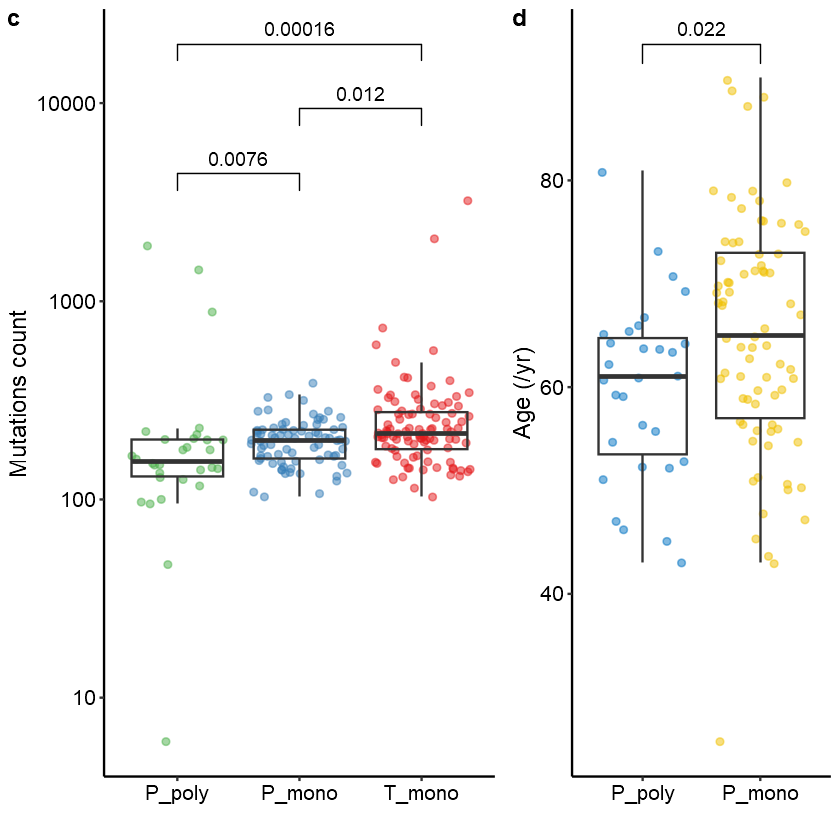

In [50]:
plot_grid(plotlist = list(p1,p2),rel_widths = c(1.5,1),ncol=2,labels = c('c','d'),label_fontface = 2)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/fig4cd.pdf",width = 5.5,height = 3)
dev.off()

In [54]:
dat %>% filter(grepl("P$",Sample)) %>% #filter(total_SNP>50) %>% 
group_by(Lineage) %>% dplyr::summarise(y=mean(Age))
dat %>% filter(grepl("P$",Sample)) %>% #filter(total_SNP>50) %>%
group_by(Lineage) %>% dplyr::count() %>% mutate(f=n/107)

Lineage,y
<chr>,<dbl>
Monoclonal,64.93506
Polyclonal,59.83333


Lineage,n,f
<chr>,<int>,<dbl>
Monoclonal,77,0.7196262
Polyclonal,30,0.2803738


In [56]:
#fig4f,g

In [59]:
#fig4f
p3=Top50_genestat %>% filter(Gene %in% cutoff) %>% 
dplyr::mutate(Gene=as.character(Gene),Gene=factor(Gene,levels=rev(as.character(t$Gene))),
       derived=as.character(derived),derived=factor(derived,levels=derived %>% unique() %>% rev() )
      ) %>%
ggplot(aes(x=Gene,y=frac)) + geom_bar(aes(fill=derived),stat="identity",position = 'dodge',alpha=0.8) +
  scale_fill_brewer(palette = 'Set1')+scale_y_continuous(breaks=seq(0,100,by=25),limits = c(0,100),position="right") +
  ylab("Percentage of patients")+xlab('')+ 
  theme_bw()+theme(panel.grid = element_blank(),
                   panel.border = element_blank(),
                   plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9,0.2),
        legend.title  = element_text(size=10),
        legend.text = element_text(size=8),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text.x = element_text(size=8,colour = "black"),
        axis.ticks = element_line(size=0.4),
        axis.text.y = element_text(size=8,colour = "black",vjust = 0.5,hjust=1,face="italic"),
        axis.title = element_text(size=10,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )+guides(fill = guide_legend(title = ""))+coord_flip()

#fig4g
library(ggridges)
library(reshape2)
maf_top30_snv=maf_driver_snv_all %>% filter(Patient_ID != "B082" & Patient_ID != "B127") %>% filter(Hugo_Symbol %in% cutoff) %>% 
mutate(CCF_adj=ifelse(CCF_adj>1,1,CCF_adj),derived=dat[match(Tumor_Sample_Barcode,dat$Sample),'derived']) %>%  filter(derived!="T_Polyclonal") %>%
mutate(Hugo_Symbol=factor(Hugo_Symbol,levels = rev(c('APC','SPTA1','ZFP36L2','TCF7L2','BCL9L','SMARCA4','FBXW7','CTNNB1','SOX9',
                                                     'KRAS','TP53','FAT4','FAT3','PCDH17','ARID1A','LRP1B','PIK3CA','SMAD4'))) )
p4 <- maf_top30_snv %>% filter(grepl("T$|P$",Tumor_Sample_Barcode) ) %>%
  ggplot(aes(x=CCF_adj,y=Hugo_Symbol,fill=derived))+
  geom_density_ridges(scale=2.95,size=0.25,alpha=0.4,color="white"
                      #from=0,to=1.5,jittered_points=T,point_shape="|",point_size=3,position = position_points_jitter(height = 0)
            )+
  scale_y_discrete(expand = c(0.01,0),name="")+scale_x_continuous(expand = c(0,0),breaks = seq(0,1.5,by=0.5),name = "Cancer cell fraction")+
  scale_fill_brewer(palette = 'Set1',direction = -1)+
  theme_bw() +theme(panel.grid = element_blank(),
        panel.border=element_rect(colour = "black",size = 0.5),
        plot.title = element_text(hjust = 0))+
  theme(legend.position = "right",
        legend.text = element_text(size=8),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text.x = element_text(size=8,colour = "black"),
        axis.text.y = element_text(size=8,colour = "black",face="italic"),
        axis.ticks = element_line(size=0.5),
        axis.title = element_text(size=10,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )  

Picking joint bandwidth of 0.109



null device 
          1

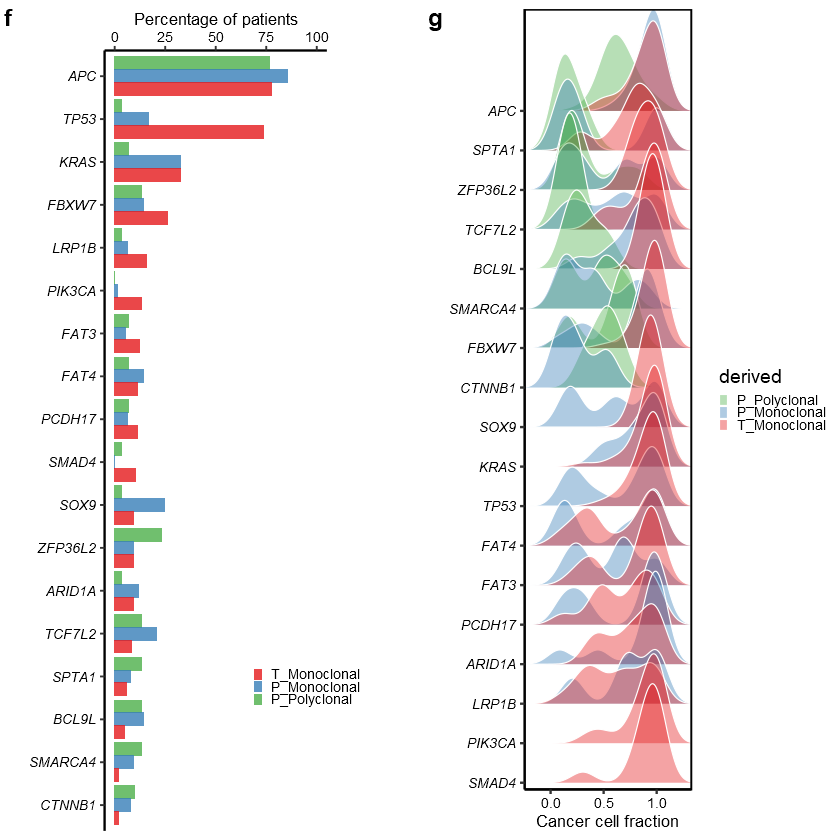

In [60]:
plot_grid(plotlist = list(p3,NULL,p4),ncol=3,rel_widths = c(0.8,0.2,1),labels = c('f','','g'),label_fontface = 2)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/fig4fg.pdf",width = 9,height = 6)
dev.off()

## fig4i_dnds

In [62]:
dndsout_lists=list(pp_dndsout,pm_dndsout,tm_dndsout)
names(dndsout_lists)=c("PP","PM","TM")

In [64]:
dnds_type_names = 
  type_names = c(
  "wmis" = "Missense",
  "wtru" = "Truncating",
  "wnon" = "Nonsense",
  "wspl" = "Splice-site"
)


gene_lists = c(
  "all_genes",
  "IntOGen-DriverGenes_COREAD",
  "IntOGen-DriverGenes_COREAD_sc_drivers_rm",
  "CRC_drivers_Cross2018_Tier1",
  "coad_driver_genes_tcga_2012",
  "driver_genes_martincorena_2017",
  "driver_genes_tarabichi_2018",
  "chromatin_modifers_selected",
  "chromatin_modifer_genes",
  "IntOGene_custom"
)

gene_lists = 
  THmisc::gene_lists[gene_lists] %>% 
  magrittr::set_names(gene_lists)

gene_lists$all_genes = 
  gene_lists$all_genes %>% 
  (function(x) x[!x %in% setdiff(gene_lists$all_genes,gene_list) ])

gene_lists$driver_genes_martincorena_2017 = 
  gene_lists$driver_genes_martincorena_2017 %>% 
  (function(x) x[!x %in% setdiff(gene_lists$driver_genes_martincorena_2017,gene_list) ])
   
gene_lists$IntOGene_custom = "./runtime/CRC_driver_678.txt" %>% readr::read_table(col_names = F) %>% dplyr::select(X1) %>% unlist() 
gene_lists$IntOGene_custom =
   gene_lists$IntOGene_custom %>% 
  (function(x) x[!x %in% setdiff(gene_lists$IntOGene_custom,gene_list) ])   

summary(gene_lists)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  X1 = col_character()
)



                                         Length Class  Mode     
all_genes                                18170  -none- character
IntOGen-DriverGenes_COREAD                  72  -none- character
IntOGen-DriverGenes_COREAD_sc_drivers_rm     0  -none- NULL     
CRC_drivers_Cross2018_Tier1                 15  -none- character
coad_driver_genes_tcga_2012                 37  -none- character
driver_genes_martincorena_2017             365  -none- character
driver_genes_tarabichi_2018                193  -none- character
chromatin_modifers_selected                  0  -none- NULL     
chromatin_modifer_genes                      0  -none- NULL     
IntOGene_custom                            671  -none- character

In [66]:
gene_set_labels = c(
  "all_genes" = "All",
  "IntOGen-DriverGenes_COREAD" = "IntOGen",
  "IntOGen-DriverGenes_COREAD_sc_drivers_rm" = "IntOGen (exc. subclonal drivers)",
  "CRC_drivers_Cross2018_Tier1" = "Cross et al. (2018)",
  "coad_driver_genes_tcga_2012" = "TCGA (2012)",
  "driver_genes_martincorena_2017" = "Martincorena et al. (2017)",
  "driver_genes_tarabichi_2018" = "Tarabichi et al. (2018)",
  "chromatin_modifers_selected" = "Chromatin modifiers (selected)",
  "Oncogene" = "Oncogenes",
  "TSG" = "TSG",
  "chromatin_modifer_genes" = "Chromatin modifiers (all)",
  "chromatin_modifer_genes_reactome" = "Chromatin modifiers (Reactome)"
)

In [65]:
keyset=c("all_genes","IntOGen-DriverGenes_COREAD","driver_genes_martincorena_2017")
globaldnds=NULL
for(i in 1:length(dndsout_lists) ){    
    for(j in 1:length(keyset)){
        geneset_dnds=genesetdnds(dndsout_lists[[i]],gene_list = gene_lists[[ keyset[j] ]])
        tmpdnds=data.frame(name=gsub("_geneset","",rownames(geneset_dnds$globaldnds_geneset) ),geneset_dnds$globaldnds_geneset)
        tmpdnds$derived=names(dndsout_lists)[i]
        tmpdnds$geneset=keyset[j]
        globaldnds=rbind(globaldnds,tmpdnds)
    }
    

}

In [67]:
genesets = c("All","IntOGen","Martincorena et al. (2017)")
cols = c("#e63946","#457b9d","#83c5be")

In [68]:
d_cur_m = globaldnds %>% filter(derived != "P") %>% 
dplyr::filter(name %in% c("wmis","wtru","wnon")) %>% 
dplyr::mutate(name = dnds_type_names[match(name,names(dnds_type_names))] ) %>%
dplyr::filter(geneset %in% names(gene_set_labels) ) %>%
dplyr::mutate(geneset = gene_set_labels[match(geneset,names(gene_set_labels))] ) %>%
dplyr::mutate(variant_group=factor(derived, levels = c("PP","PM","TM")) )  %>% 
dplyr::mutate(x_pos = as.numeric(variant_group)) %>%
dplyr::mutate(gene_set_label = factor(geneset,levels = genesets ) ) %>%
dplyr::mutate(x_offset = as.numeric(gene_set_label)) %>%
dplyr::mutate(x_offset = ((x_offset - 1) - (length(levels(gene_set_label)) - 1) / 2) / (length(levels(gene_set_label))) / 2) 
levels(d_cur_m$variant_group) = c("P_poly", "P_mono","T_mono") 

In [69]:
p6=d_cur_m %>%
ggplot(aes(x=x_pos+x_offset,
           y=mle,ymin=cilow,ymax=cihigh,color=gene_set_label,group=gene_set_label))+geom_pointrange(size=0.1)+
  xlab("")+ylab("dN/dS")+scale_y_log10(limits = c(0.1,100))+
  scale_x_continuous(breaks=seq_along(levels(d_cur_m$variant_group)), labels=levels(d_cur_m$variant_group)) +
  geom_hline(yintercept = 1,lty = 2)+
  scale_color_npg()+
  theme_bw() +theme(panel.grid = element_blank(),
        panel.border=element_blank(),
        plot.title = element_text(hjust = 0))+
  guides(color = guide_legend(title="Genes")) +
  theme(legend.position = "bottom",
        legend.title  = element_text(size=8),
        legend.text = element_text(size=8),
        panel.spacing=unit(1,'cm'),
        legend.key.size =unit(0.2,'cm') ) +
  theme(
        axis.text.y = element_text(size=10,colour = "black"),
        axis.ticks = element_line(size=0.8),
        axis.line = element_line(colour = "black",size = 0.5)) +
  facet_grid(~name, scales="free_x",space='free')+
  theme(
        strip.background = element_blank(),
        strip.text.x = element_text(angle=0,size=8,colour = "black",face = "bold.italic") )+ 
  coord_cartesian(clip = 'off') + 
  scale_alpha_identity()    



null device 
          1

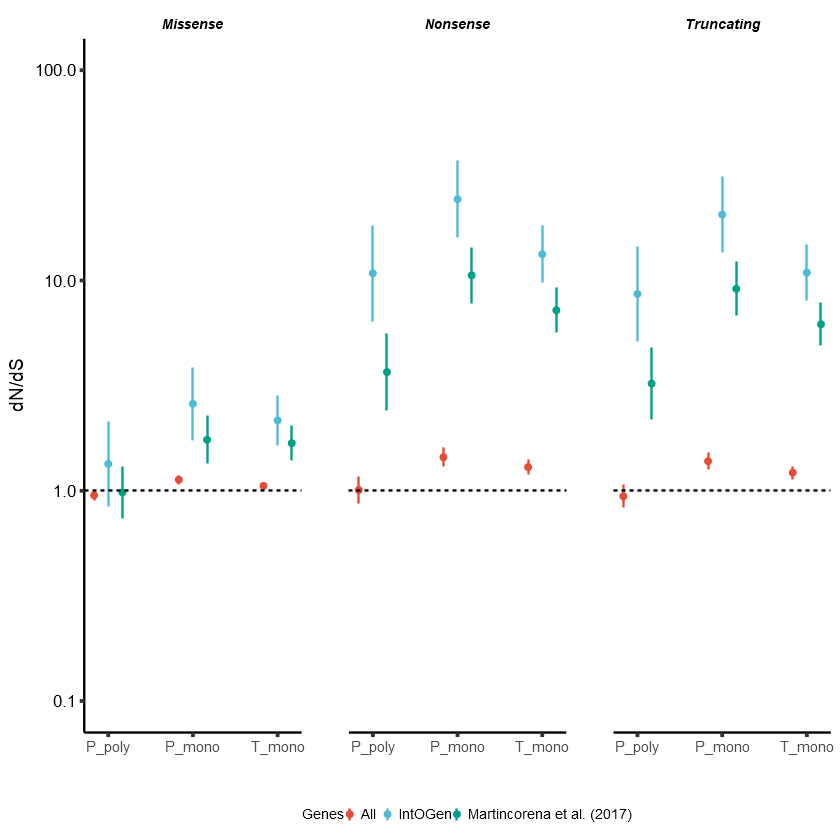

In [70]:
print(p6)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/fig4fi.pdf",width = 5,height = 3)
dev.off()

## fig4e_cnv

Using Sample, derived as id variables



null device 
          1

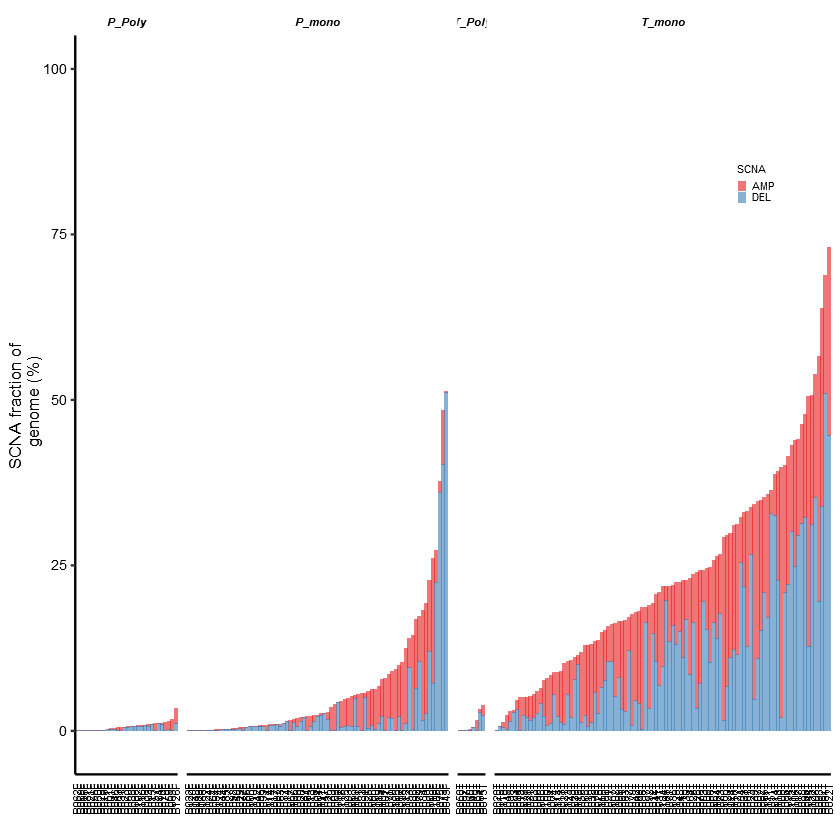

In [309]:
p5<- dat %>% filter(grepl("T$|P$",Sample))%>% 
dplyr::mutate(derived=as.character(derived),
       derived=factor(derived,
                      levels=c("P_Polyclonal","P_Monoclonal","T_Polyclonal","T_Monoclonal") ) ) %>% 
arrange(derived,FLA,AMP) %>% mutate(Sample=factor(Sample,levels=unique(Sample) ) ) %>%
select(Sample,AMP,DEL,derived) %>% reshape2::melt() %>% dplyr::rename(c("Frac"="value","SCNA"="variable"))%>%
  ggplot( aes(x=Sample,y=Frac,fill=SCNA))+geom_bar(stat="identity",position = 'stack',alpha=0.6) +ylim(-1.5,100)+
  scale_fill_brewer(palette = 'Set1')+ylab("SCNA fraction of \n genome (%)")+xlab('')+
  facet_grid(~derived,scales = "free_x",space = "free_x",labeller =as_labeller(c('P_Polyclonal'='P_Poly','P_Monoclonal'='P_mono','T_Polyclonal'='T_Poly','T_Monoclonal'='T_mono')) )+
  theme_bw()+theme(panel.grid = element_blank(),
                   panel.border = element_blank(),
                   plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9,0.8),
        legend.title  = element_text(size=6),
        legend.text = element_text(size=6),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text.x = element_text(size=6,colour = "black",angle = 90,vjust = 0.5),
        axis.ticks.x = element_blank(),
        axis.text.y = element_text(size=8,colour = "black"),
        axis.ticks.y = element_line(size=0.5),
        axis.title = element_text(size=10,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )+theme(strip.background = element_blank(),
   strip.text.x = element_text(size=6,colour = "black",face = "bold.italic") )+
guides(fill = guide_legend(title = "SCNA")) #+geom_rug(sides="b",aes(color=derived))+scale_color_brewer(palette = 'Set1',direction = -1) #geom_tile(aes(x=ID,y=-1,fill=derived)) #
print(p5)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/fig4e_u.pdf",width = 12,height = 3)
dev.off()

In [261]:
## cnv landscape

In [273]:
# Chromosome sizes, for binning and plotting coordinates
binGenome <- function(chromSizesPath){
  chromCoords <- read.csv(chromSizesPath, sep="\t", stringsAsFactors = FALSE, header = FALSE, col.names = c("chr", "size"))
  chromCoords$chr <- gsub("chr", "", chromCoords$chr)
  chromCoords$start <- cumsum(as.numeric(c(1,chromCoords$size[1:nrow(chromCoords)-1])))
  chromCoords$cumsum <- cumsum(as.numeric(chromCoords$size))
  chromCoords$color <- ifelse(c(1:length(chromCoords$chr))%%2 ==0, yes="black", no="gray")
  chromCoords
}


hg38.genome.sizes <- "D:/2.crc_trio/src/cnv-heatmap-master/data/hg38.chrom.exclued.XY.sizes.txt"
chromCoordsHg38 <- binGenome(hg38.genome.sizes)

chromCoordsHg38[1:2,]

,chr,size,start,cumsum,color
,<chr>,<int>,<dbl>,<dbl>,<chr>
1,1,248956422,1,248956422,gray
2,2,242193529,248956423,491149951,black


In [274]:
seg_raw=read.table('./7.gistic2/CRC_SCNA_segs.txt',header = T,sep="\t")
seg=seg_raw %>% filter(grepl("P$|T$",ID)) %>% select(ID,chrom,loc.start,loc.end,num.mark,seg.mean.adj)
seg<-readSeg2(seg,chromCoordsHg38)

In [275]:
coords <- chromCoordsHg38
rownames(coords)=coords$chr
coordMat <- do.call(rbind, lapply(coords$chr,
                      function(i) {chr.i <- subset(coords, chr==i);
                      return(data.frame(row=seq(chr.i$start, chr.i$cumsum, by=100000), chr=i))}))
coordMat$chr=factor(coordMat$chr,levels=unique(coordMat$chr))

coordMat[1:2,]
levels(coordMat$chr)

,row,chr
,<dbl>,<fct>
1,1,1
2,100001,1


[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22"

In [276]:
samples <- unique(seg$Sample)
cnvMat <- matrix(rep(rep(0,nrow(coordMat)),length(samples)),ncol=length(samples))
colnames(cnvMat) <- samples
populate.binned.data <- function(start, end, column, value){ cnvMat[(start/100000):(end/100000), column] <<- value}

In [277]:
cnvMat <- populateCNVMatrix(chromCoords = coords,
                              coordMat = coordMat,
                              segDf = seg)

cnvMat[1:6,]
dim(cnvMat)

,B001P,B001T,B002P,B002T,B003P,B003T,B004P,B004T,B005P,B005T,...,B122T,B123P,B123T,B124P,B124T,B125P,B125T,B126P,B126T,B127P
1,-0.259,-0.961,-0.312,0.564,0.169,0.87,-0.069,0.557,0.003,0.602,...,0.874,-0.269,-0.498,0.021,-0.702,-0.161,0.027,0.135,0.419,-0.151
1,-0.259,-0.961,-0.312,0.564,0.169,0.87,-0.069,0.557,0.003,0.602,...,0.874,-0.269,-0.498,0.021,-0.702,-0.161,0.027,0.135,0.419,-0.151
1,-0.259,-0.961,-0.312,0.564,0.169,0.87,-0.069,0.557,0.003,0.602,...,0.874,-0.269,-0.498,0.021,-0.702,-0.161,0.027,0.135,0.419,-0.151
1,-0.259,-0.961,-0.019,0.564,-0.036,0.87,-0.069,0.557,0.003,0.602,...,0.874,-0.015,0.119,0.021,-0.702,-0.161,0.027,0.135,0.419,-0.151
1,0.078,-0.554,-0.019,0.564,-0.036,0.87,-0.069,0.557,0.003,0.602,...,0.874,-0.015,0.119,0.021,-0.702,-0.152,0.027,-0.069,-0.136,-0.197
1,0.078,-0.554,-0.019,0.564,-0.036,0.87,-0.069,0.557,0.003,0.602,...,0.874,-0.015,0.119,0.021,-0.702,-0.152,0.027,-0.069,-0.136,-0.197


[1] 28760   216

In [280]:
left_chr<-left_join(coordMat,coords[,c('chr','color')],by="chr")
left_chr=as.matrix(left_chr)
rownames(left_chr)<-left_chr[,2]

left_chr %>% head()

,row,chr,color
1,1,1,gray
1,100001,1,gray
1,200001,1,gray
1,300001,1,gray
1,400001,1,gray
1,500001,1,gray


In [310]:
cnv_anno<-dat %>% filter(grepl("T$|P$",Sample))%>% 
dplyr::mutate(derived=as.character(derived),derived=factor(derived,
                      levels=c("P_Polyclonal","P_Monoclonal","T_Polyclonal","T_Monoclonal") ) ) %>% arrange(derived,FLA,AMP) %>% 
mutate(Sample=factor(Sample,levels=unique(Sample)),Type=substr(Sample,5,5)) %>% 
select(Sample,derived,Type,Lineage,ploidy,wGII,CIN_status)

In [311]:
cnv_anno %>% head(n=2)

,Sample,derived,Type,Lineage,ploidy,wGII,CIN_status
,<fct>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,B062P,P_Polyclonal,P,Polyclonal,1.97,0.02318182,CIN-
2,B069P,P_Polyclonal,P,Polyclonal,2.01,0.04363636,CIN-


In [312]:
p5_d<-Heatmap(cnvMat[,match(cnv_anno$Sample,colnames(cnvMat))], 
              cluster_columns = FALSE,
              cluster_rows = FALSE,
              show_row_names = FALSE,
              #row_order=order(as.numeric(rownames(cnvMat))),
              #column_order=dat$ID,
              column_split=cnv_anno$derived,
              row_split = coordMat$chr,
              column_names_gp = gpar(fontsize = 8),
              left_annotation = rowAnnotation(chr=left_chr[,'color'],
                                              col=list(chr=c('black'='black','gray'='gray')),
                                              annotation_legend_param = list(title=""),
                                              simple_anno_size = unit(0.3, "cm")),
              
              bottom_annotation = HeatmapAnnotation(Type = cnv_anno$Type, 
                                                    Clonality=cnv_anno$Lineage,
                                                    Ploidy=cnv_anno$ploidy,
                                                    wGII=cnv_anno$wGII,
                                                    CIN=cnv_anno$CIN_status,
                                                simple_anno_size = unit(0.5, "cm"), 
                                                annotation_name_side="left",
                                                col=list(Type=c('T'='#E41A1C','P'='#377EB8'),
                                                         Clonality=c('Polyclonal'='#FC8D62','Monoclonal'='#66C2A5'),
                                                         Ploidy=circlize::colorRamp2(c(0,5),c("white","#309CB6")),
                                                         wGII=circlize::colorRamp2(c(0,100),c("white","#A1094B")),
                                                         CIN=c('CIN+'='#E64B35FF','CIN-'='#4DBBD5FF')
                                                        ),
                                                annotation_legend_param = list(title_position="leftcenter",
                                                                               direction="horizontal",nrow=1)                                         
                                                ),
              col = colorRamp2(c(-2, 0, 2), c("blue3", "white", "red3")),
              heatmap_legend_param = list( legend_direction = "horizontal", title_position = "lefttop"),
              name = "seg.mean")

`use_raster` is automatically set to TRUE for a matrix with more than
2000 rows. You can control `use_raster` argument by explicitly setting
TRUE/FALSE to it.

Set `ht_opt$message = FALSE` to turn off this message.



In [313]:
pdf("D:/2.crc_trio/draft/toZL/fig4_related/fig4e_d.pdf",width=12,heigh=12)
draw(p5_d, heatmap_legend_side = "bottom",annotation_legend_side="bottom")
dev.off()

png 
  2

# SupplementaryFigure

In [ ]:
##relatedness between p and T, added two published wes data refered from 

In [ ]:
load(file="D:/2.crc_trio/draft/toZL/fig4_related/PT_relatedness.RData")

In [74]:
s13a<-rls %>% dplyr::group_by(patient) %>% 
dplyr::summarize(mean_scores=round(mean(pair_scores) ,5)) %>% 
mutate(Cohort=ifelse(grepl("^B",patient),"Polyp-CRC","Li J et al(2019)" ),
       Cohort=factor(Cohort) ) %>%
  ggplot(aes(x=patient,y=mean_scores))+geom_bar(stat="identity",position = 'stack',fill="#E55709",alpha=0.7) +
  scale_fill_brewer(palette = 'Set1')+geom_hline(yintercept=0.1, linetype=5, color = "black", size=0.5)+
  ylab("Clonal relatedness score")+xlab('')+ facet_grid(~Cohort,scales = "free_x",space = "free_x")+
  scale_y_continuous(breaks=seq(0,1,by=0.25), limits=c(0,1.0))+
  theme_bw()+theme(panel.grid = element_blank(),
                   panel.border = element_blank(),
                   plot.title = element_text(hjust = 0.5))+
  theme(legend.position = "none",
        legend.title  = element_text(size=14),
        legend.text = element_text(size=12),
        legend.key.size =unit(0.2,'cm') ) +
  theme(axis.text.x = element_text(size=6,colour = "black",angle = 90,vjust = 0.5),
        axis.ticks.x = element_line(size=0.4),
        axis.text.y = element_text(size=6,colour = "black"),
        axis.ticks.y = element_line(size=0.8),
        axis.title = element_text(size=8,colour = "black"),
        axis.line = element_line(colour = "black",size=0.5)
  )

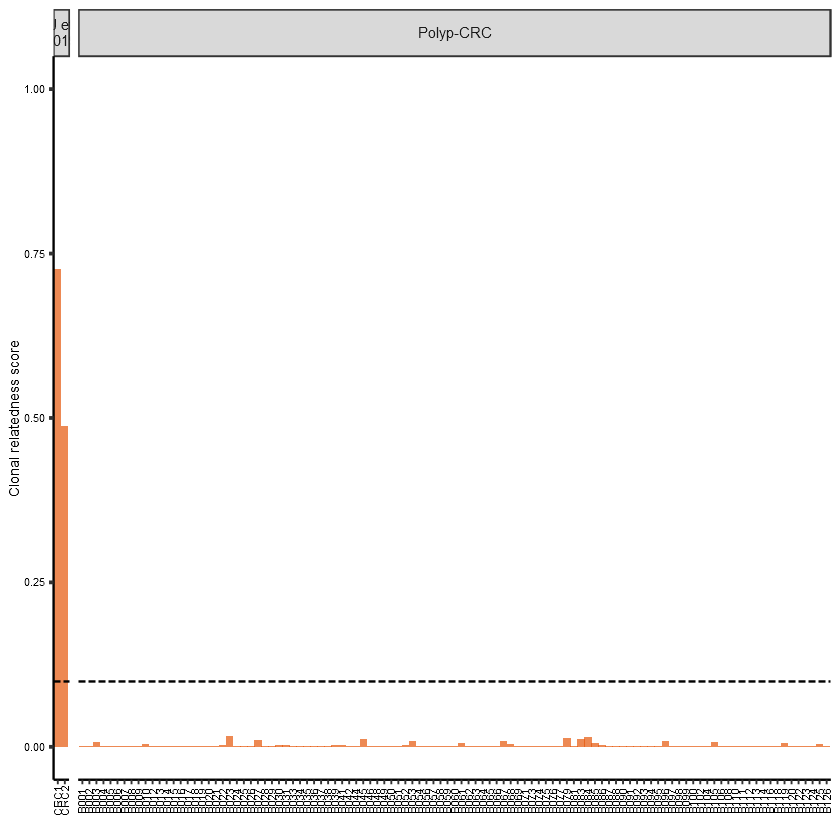

In [75]:
print(s13a)

In [208]:
summary(maf_top30_snv$CCF_adj)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0810  0.6300  0.9080  0.7805  1.0000  1.0000 

In [52]:
driverGene<-read.table("./runtime/CRC_driver_678.txt",header=F,sep="\t")
colnames(driverGene)='gene'
fun_cls=c("Missense_Mutation","Nonsense_Mutation","Nonstop_Mutation","Splice_Site","In_Frame_Ins","In_Frame_Del","Frame_Shift_Del","Frame_Shift_Ins")
clin<-read.xlsx("./0.库检/7.肠镜标本病理.xlsx",sheet = 1,colNames = T,cols = c(1:31))
clin<-clin %>% mutate(T=gsub(";n2","",T_site),P=gsub(";n2","",P_site))

pts=unique(dat$Patient)
sta=list()
ccf=list()
for (n in 1:length(pts)) {
    comb=NULL
    sn=dat$Sample[which(dat$Patient==pts[n])]
    for (i in sn) {
        tmp=ls_escc_af[[i]]
        tmp=tmp[which(tmp$Clonality!='Unknown'),]
        tmp=tmp[which(tmp$Alt_allele_depth>=5 & tmp$Total_allele_depth>=10),c(1:5,7,12,8,grep("CCF_adj",names(tmp)))]
        colnames(tmp)[9]=i
        if(is.null(comb)){
            comb=tmp
         }else{
            comb=dplyr::full_join(comb,tmp,by=c(colnames(tmp)[1:8]))
        }     
    }
    
     if(length(sn)>1){
         comb[,9:ncol(comb)]=apply(comb[,9:ncol(comb)],2,function(x){ x[which(is.na(x))]=0; x})
         LP=apply(as.data.frame(comb[,which(names(comb) %in% sn[grep("P",sn)])]/2),1,function(x){length(which(x>0.04))})
         LT=apply(as.data.frame(comb[,which(names(comb) %in% sn[grep("T",sn)])]/2),1,function(x){length(which(x>0.04))})
         idx=apply(comb[,9:ncol(comb)]/2,1,function(x){paste0("private=",names(x)[which(x>0.04)],collapse = ",")})
         if(length(LP)==0) LP=0
         if(length(LT)==0) LT=0
         comb$PubOrSub=ifelse(LP>=1 & LT>=1, "public", idx)
         pubidx=which(comb$PubOrSub=="public")
        }
    
    comb=comb %>% mutate(labels=paste0(Hugo_Symbol,aaChange),
                labels=ifelse(grepl(paste(driverGene$gene,collapse = "|"),Hugo_Symbol),labels,''),
                labels=ifelse(grepl(paste(fun_cls,collapse = "|"),Variant_Classification),labels,''),
                top_labs=ifelse(grepl(paste(Top50_driver[1:20],collapse = "|"),Hugo_Symbol),labels,'')        
                    )
    sta[[pts[n]]]=comb
    ccf[[pts[n]]]=as.data.frame(comb[,sn])
}


In [63]:
## Figure S13
pairs_plot=list()
j=0
for(i in c(7,1,24)){ #length(sta)
     #i=1
     gg=sta[[i]]
     gg$P=gg[,grep('P$',colnames(gg))]
     gg$T=gg[,grep('T$',colnames(gg))]
     j=j+1
     pairs_plot[[j]]<-gg %>% mutate(P=ifelse(P>1,1,P),T=ifelse(T>1,1,T)) %>% ggplot(aes(x=P,y=T)) +
     stat_density2d(aes(fill = ..density..), geom = "tile", contour = FALSE, n = 300) +
     scale_fill_continuous(low = "white", high = "#e55709")+geom_point(color="grey",shape=21,size=0.5)+labs(subtitle=names(sta[i])) +
     xlab(paste0('CCF in polyp','\n','(',clin[which(clin$PatientID==names(sta[i])),'P'],')'))+
     ylab(paste0('CCF in tumor','\n','(',clin[which(clin$PatientID==names(sta[i])),'T'],')'))+
     scale_x_continuous( breaks=c(0,0.25,0.5,0.75,1), labels=c('0.00','0.25','0.50','0.75','1.00'), limits=c(-0.1,1.1))+
     scale_y_continuous( breaks=c(0,0.25,0.5,0.75,1), labels=c('0.00','0.25','0.50','0.75','1.00'), limits=c(-0.1,1.1))+
     theme_classic() + 
     theme(legend.position = 'none',
             plot.subtitle = element_text(size=10,colour = "black"),
             axis.text = element_text(size=6,colour = "black"),
             axis.ticks = element_line(size=0.8),
             axis.title = element_text(size=8,colour = "black"),
             axis.line = element_line(colour = "black",size=0.5)
     )+geom_text_repel(aes(label=top_labs,fontface=3),size=1.8,min.segment.length = 0, seed = 42,box.padding = 0.5, max.overlaps = Inf)
}

Warning message:
"Removed 1196 rows containing missing values (`geom_tile()`)."
Warning message:
"Removed 1196 rows containing missing values (`geom_tile()`)."
Warning message:
"Removed 1196 rows containing missing values (`geom_tile()`)."


null device 
          1

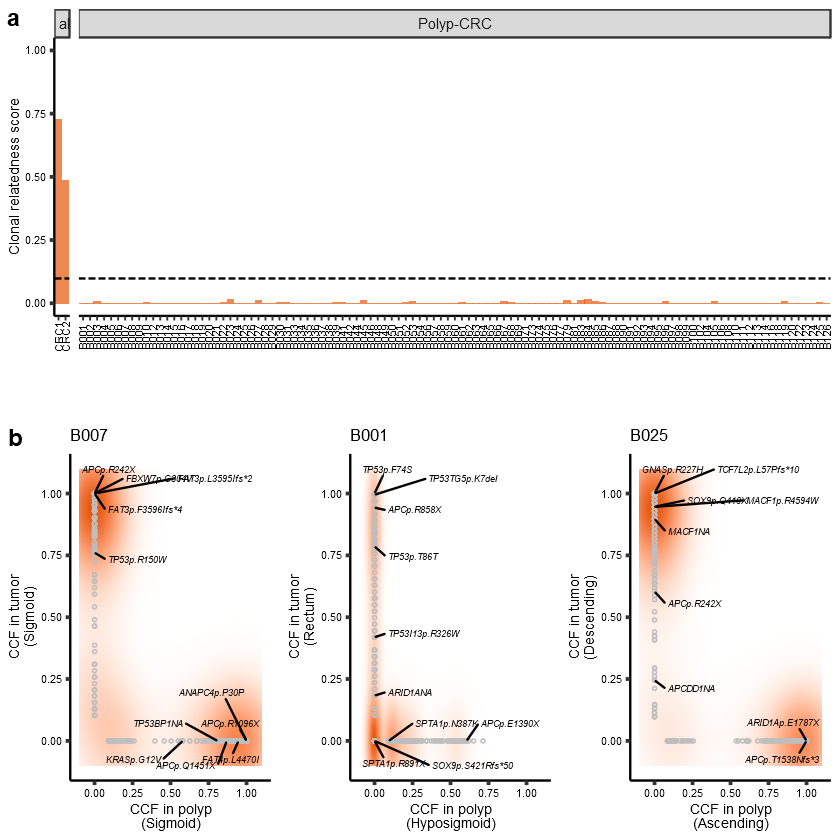

In [73]:
plot_grid(s13a,NULL,plot_grid(plotlist = pairs_plot,nrow = 1),
          ncol=1,labels = c('a','','b'),label_fontface = 2,rel_heights=c(0.9,0.1,1)
)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/figS13.pdf",width = 10,height = 6)
dev.off()

In [70]:
#2. Figure S15, wGII
s16a<-dat %>% filter(grepl("P$|T$",Sample)) %>% filter(derived!="T_Polyclonal") %>%
    ggplot(aes(x=derived,y=wGII)) + geom_jitter(aes(color=derived),alpha=.5) + geom_boxplot(outlier.shape = NA,fill=NA)+  
scale_color_brewer(palette = "Set1",direction = -1)+xlab("")+ylab("wGII")+
  stat_compare_means(comparisons=list(c("P_Monoclonal","P_Polyclonal"),
                                      c("P_Monoclonal","T_Monoclonal"),
                                      c("P_Polyclonal","T_Monoclonal")
                                      ),label = "p.format",label.x = 1.3)+
mytheme+scale_x_discrete(breaks=c("P_Polyclonal","P_Monoclonal","T_Monoclonal"), labels=c('P_poly','P_mono','T_mono'))

pVal1=fisher.test(matrix(c(0,28,11,68),nrow = 2),alternative = "less") # p_poly vs p_mono
pVal2=fisher.test(matrix(c(0,28,60,47),nrow = 2),alternative = "less") # p_poly vs t_mono
pVal3=fisher.test(matrix(c(11,68,60,47),nrow = 2),alternative = "less") # p_mono vs t_mono

s16b<-dat %>% filter(grepl("P$|T$",Sample)) %>% filter(derived!="T_Polyclonal") %>% 
dplyr::group_by(derived,CIN_status) %>% dplyr::count() %>% as.data.frame %>%  dplyr::rename(c("Sample"="n")) %>%
ggbarplot(x = "derived",y = "Sample",label = TRUE,lab.pos = "in" ,xlab = "",fill = "CIN_status",color = NA,alpha=0.8)+
  scale_fill_aaas()+
  ylab("Number of samples")+xlab('')+
  stat_signif(comparisons = list(c("P_Polyclonal","P_Monoclonal")),annotations =signif(pVal1$p.value,3) ,y_position = 80)+
  stat_signif(comparisons = list(c("P_Monoclonal","T_Monoclonal")),annotations =signif(pVal2$p.value,3) ,y_position = 107)+
  stat_signif(comparisons = list(c("P_Polyclonal","T_Monoclonal")),annotations =signif(pVal3$p.value,3) ,y_position = 115)+
theme_bw()+theme(panel.grid = element_blank(),
                   panel.border= element_blank(),
                   plot.title = element_text(hjust = 0.5))+
mytheme+scale_x_discrete(breaks=c("P_Polyclonal","P_Monoclonal","T_Monoclonal"), labels=c('P_poly','P_mono','T_mono'))+
theme(legend.position = "right")+guides(fill = guide_legend(title = "Status"))


plot_grid(plotlist = list(s16a,NULL,s16b),rel_widths = c(0.9,0.2,0.9),ncol=3,labels = c('a','','b'),label_fontface = 2)
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/figS16.pdf",width = 8,height = 4)
dev.off()

ERROR: Error in eval(expr, envir, enclos): 找不到对象'mytheme'


## sfs pattern ammong P and T

In [477]:
 ##a. polyps
  ## p-sfs
 n=grep("P$",names(ls_escc_af))
 tmp=do.call("rbind", lapply(ls_escc_af[n], function(x) {colnames(x)[20:21]=c('N_cover','N_alt_freq'); x }) )
 tmp=tmp[which(tmp$Alt_allele_depth>=5 & tmp$Total_allele_depth>=10),] #Tumor_Sample_Barcode
 tmp$vaf_adj=tmp$CCF_adj/2
 tmp=tmp[which(tmp$Clonality!='Unknown'),]
 tmp$type=tmp$Clonality
 sfs_pp=tmp %>% filter(Tumor_Sample_Barcode %in% (dat %>% filter(Lineage=="Polyclonal" & grepl("P$",Sample)) %>% select(Sample) %>% t() %>% as.vector() ) ) %>% 
 ggplot(aes(x=vaf_adj,y=Tumor_Sample_Barcode,fill=stat(x) ))+
   geom_density_ridges_gradient(scale = 0.9, size = 0.3, rel_min_height = 0.01)+
   scale_fill_viridis_c(name = "vaf_adj", option = "C")+
   theme_ridges(font_family = "Roboto Condensed", grid = F)+
   facet_wrap(~Tumor_Sample_Barcode,scales="free_y",ncol=6)+
     guides(fill = guide_legend(title = "")) + 
     labs(
       x = "Cancer cell fraction",
       y = "density"
     ) +mobster:::my_ggplot_theme()+theme_classic()+
   theme(legend.position = "none",axis.text.y = element_text(angle = 90,hjust = 0),axis.ticks.y = element_blank(),strip.background = element_rect(color = "white", fill = "white"),panel.grid = element_blank(),strip.text = element_blank() )+
   geom_vline(xintercept=0.5, linetype=5, color = "black", size=0.5)+scale_x_continuous(breaks=c(0,0.25,0.50,0.75,1.00),labels=c("0.00","0.50","1.00","1.50","2.00"),limits = c(0,1))

 sfs_mp=tmp %>% filter(Tumor_Sample_Barcode %in% (dat %>% filter(Lineage=="Monoclonal" & grepl("P$",Sample)) %>% select(Sample) %>% t() %>% as.vector() ) ) %>% 
 ggplot(aes(x=vaf_adj,y=Tumor_Sample_Barcode,fill=stat(x) ))+
   geom_density_ridges_gradient(scale = 0.9, size = 0.3, rel_min_height = 0.01)+
   scale_fill_viridis_c(name = "vaf_adj", option = "C")+
   theme_ridges(font_family = "Roboto Condensed", grid = F)+
   facet_wrap(~Tumor_Sample_Barcode,scales="free_y",ncol=6)+
     guides(fill = guide_legend(title = "")) + 
     labs(
       x = "Cancer cell fraction",
       y = "density"
     ) +mobster:::my_ggplot_theme()+theme_classic()+
   theme(legend.position = "none",axis.text.y = element_text(angle = 90,hjust = 0),axis.ticks.y = element_blank(),strip.background = element_rect(color = "white", fill = "white"),panel.grid = element_blank(),strip.text = element_blank() )+
   geom_vline(xintercept=0.5, linetype=5, color = "black", size=0.5)+scale_x_continuous(breaks=c(0,0.25,0.50,0.75,1.00),labels=c("0.00","0.50","1.00","1.50","2.00"),limits = c(0,1))

 ## t-sfs
 n=grep("T$",names(ls_escc_af))
 tmp=do.call("rbind", lapply(ls_escc_af[n], function(x) {colnames(x)[20:21]=c('N_cover','N_alt_freq'); x }) )
 tmp=tmp[which(tmp$Alt_allele_depth>=5 & tmp$Total_allele_depth>=10),] #Tumor_Sample_Barcode
 tmp$vaf_adj=tmp$CCF_adj/2
 tmp=tmp[which(tmp$Clonality!='Unknown'),]
 tmp$type=tmp$Clonality
 sfs_tp=tmp %>% filter(Tumor_Sample_Barcode %in% (dat %>% filter(Lineage=="Polyclonal"  & grepl("T$",Sample)) %>% select(Sample) %>% t() %>% as.vector() ) ) %>% 
 ggplot(aes(x=vaf_adj,y=Tumor_Sample_Barcode,fill=stat(x) ))+
   geom_density_ridges_gradient(scale = 0.9, size = 0.3, rel_min_height = 0.01)+
   scale_fill_viridis_c(name = "vaf_adj", option = "C")+
   theme_ridges(font_family = "Roboto Condensed", grid = F)+
   facet_wrap(~Tumor_Sample_Barcode,scales="free_y",ncol=6)+
     guides(fill = guide_legend(title = "")) + 
     labs(
       x = "Cancer cell fraction",
       y = "density"
     ) +mobster:::my_ggplot_theme()+theme_classic()+
   theme(legend.position = "none",axis.text.y = element_text(angle = 90,hjust = 0),axis.ticks.y = element_blank(),strip.background = element_rect(color = "white", fill = "white"),panel.grid = element_blank(),strip.text = element_blank() )+
   geom_vline(xintercept=0.5, linetype=5, color = "black", size=0.5)+scale_x_continuous(breaks=c(0,0.25,0.50,0.75,1.00),labels=c("0.00","0.50","1.00","1.50","2.00"),limits = c(0,1))

 sfs_tm=tmp %>% filter(Tumor_Sample_Barcode %in% (dat %>% filter(Lineage=="Monoclonal"  & grepl("T$",Sample)) %>% select(Sample) %>% t() %>% as.vector() ) ) %>% 
 ggplot(aes(x=vaf_adj,y=Tumor_Sample_Barcode,fill=stat(x) ))+
   geom_density_ridges_gradient(scale = 0.9, size = 0.3, rel_min_height = 0.01)+
   scale_fill_viridis_c(name = "vaf_adj", option = "C")+
   theme_ridges(font_family = "Roboto Condensed", grid = F)+
   facet_wrap(~Tumor_Sample_Barcode,scales="free_y",ncol=6)+
     guides(fill = guide_legend(title = "")) + 
     labs(
       x = "Cancer cell fraction",
       y = "density"
     ) +mobster:::my_ggplot_theme()+theme_classic()+
   theme(legend.position = "none",axis.text.y = element_text(angle = 90,hjust = 0),axis.ticks.y = element_blank(),strip.background = element_rect(color = "white", fill = "white"),panel.grid = element_blank(),strip.text = element_blank() )+
   geom_vline(xintercept=0.5, linetype=5, color = "black", size=0.5)+scale_x_continuous(breaks=c(0,0.25,0.50,0.75,1.00),labels=c("0.00","0.50","1.00","1.50","2.00"),limits = c(0,1))


Picking joint bandwidth of 0.0189

Picking joint bandwidth of 0.0225

Picking joint bandwidth of 0.0122

Picking joint bandwidth of 0.0256

Picking joint bandwidth of 0.0109

Picking joint bandwidth of 0.0248

Picking joint bandwidth of 0.00768

Picking joint bandwidth of 0.0103

Picking joint bandwidth of 0.051

Picking joint bandwidth of 0.0571

Picking joint bandwidth of 0.049

Picking joint bandwidth of 0.0487

Picking joint bandwidth of 0.0497

Picking joint bandwidth of 0.0259

Picking joint bandwidth of 0.0356

Picking joint bandwidth of 0.0126

Picking joint bandwidth of 0.041

Picking joint bandwidth of 0.0353

Picking joint bandwidth of 0.0533

Picking joint bandwidth of 0.0191

Picking joint bandwidth of 0.0299

Picking joint bandwidth of 0.0419

Picking joint bandwidth of 0.045

Picking joint bandwidth of 0.0449

Picking joint bandwidth of 0.029

Picking joint bandwidth of 0.0281

Picking joint bandwidth of 0.0489

Picking joint bandwidth of 0.0443

Picking joint bandwidth 

null device 
          1

Picking joint bandwidth of 0.0219

Picking joint bandwidth of 0.0231

Picking joint bandwidth of 0.0418

Picking joint bandwidth of 0.0192

Picking joint bandwidth of 0.043

Picking joint bandwidth of 0.0315

Picking joint bandwidth of 0.0216

Picking joint bandwidth of 0.0353

Picking joint bandwidth of 0.0502

Picking joint bandwidth of 0.015

Picking joint bandwidth of 0.0486

Picking joint bandwidth of 0.0434

Picking joint bandwidth of 0.0483

Picking joint bandwidth of 0.0133

Picking joint bandwidth of 0.0105

Picking joint bandwidth of 0.0232

Picking joint bandwidth of 0.0109

Picking joint bandwidth of 0.0119

Picking joint bandwidth of 0.0437

Picking joint bandwidth of 0.0149

Picking joint bandwidth of 0.0407

Picking joint bandwidth of 0.0343

Picking joint bandwidth of 0.0448

Picking joint bandwidth of 0.0396

Picking joint bandwidth of 0.0294

Picking joint bandwidth of 0.015

Picking joint bandwidth of 0.0205

Picking joint bandwidth of 0.0305

Picking joint bandwidth

null device 
          1

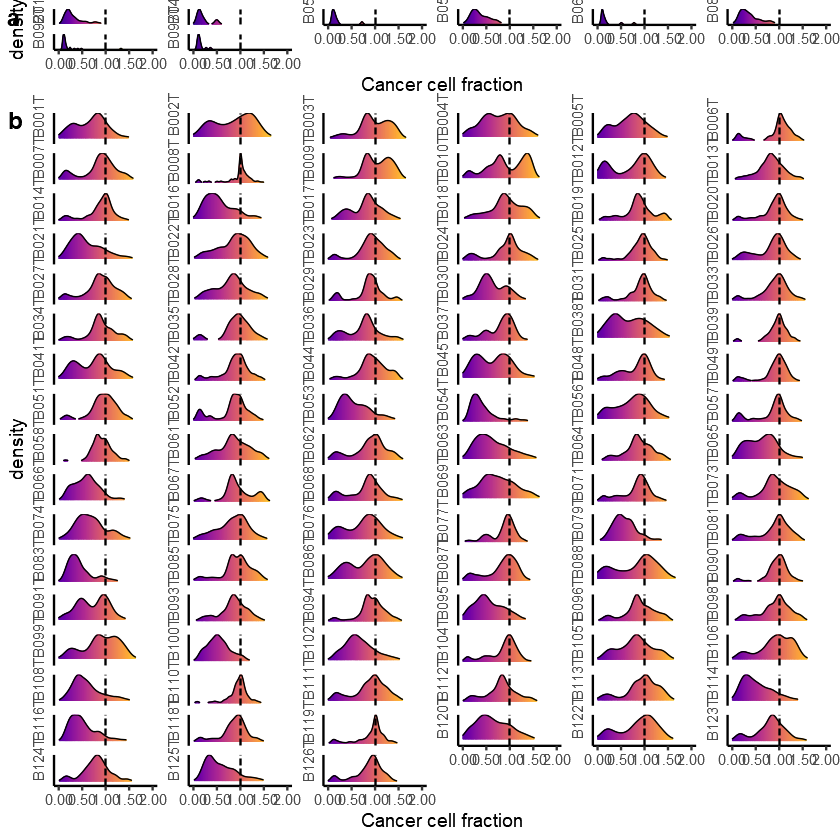

In [484]:
plot_grid(plotlist = list(sfs_tp,sfs_tm),nrow=2,rel_heights = c(1.2,8.5),labels = c('a','b'),label_fontface = 2 )
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/figS14_T.pdf",width = 12,height = 12)
dev.off()
plot_grid(plotlist = list(sfs_pp,sfs_mp),nrow=2,rel_heights = c(1,2.6),labels = c('a','b'),label_fontface = 2 )
ggsave("D:/2.crc_trio/draft/toZL/fig4_related/figS15_P.pdf",width = 12,height = 12)
dev.off()